<a href="https://colab.research.google.com/github/brenoafb/video-compression/blob/Giordano/NoteCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#!pip install bitstring
!pip install --upgrade Pillow

Requirement already up-to-date: Pillow in /usr/local/lib/python3.7/dist-packages (8.2.0)


In [5]:
%reload_ext autoreload
%autoreload 2

Includes

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import bitstring as bs
from yuv_reader import read_yuv
from block_utils import *
from compression import *
from img_utils import *

Informações sobre o vídeo: nome e dimensõe

In [7]:
filename = 'foreman_qcif.yuv'
width = 176
height = 144

In [8]:
frames = read_yuv(filename)
#frames

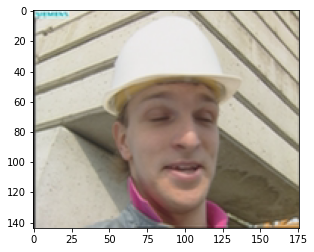

In [9]:
plt.imshow(frames[1])

In [10]:
 #for frame in frames: 
  #cv2_imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
   
    # Press Q on keyboard to  exit
  #if cv2.waitKey(25) & 0xFF == ord('q'):
    #break

In [11]:
frame = frames[1]
frame.shape

(144, 176, 3)

In [12]:
#locks_per_row, blocks_per_column

In [13]:
block_size = 16
blocks = get_blocks(frame, block_size)
for (block, coords) in blocks:
    #plt.imshow(block)
    #print(coords)
    plt.show()

In [14]:
(block, coords) = blocks[43]
#plt.imshow(block), print(coords)

In [15]:
delta = 10
mat = frames[0]
found_coords = get_matching_block(mat, block, coords[0], coords[1], delta)

In [16]:
found_block = mat[found_coords[0] : found_coords[0] + block_size, found_coords[1] : found_coords[1] + block_size, :]
#plt.imshow(found_block)

In [17]:
residual = block - found_block
#plt.imshow(residual)

In [18]:
residuals = []
motion_vectors = []
for (block, coords) in blocks:
    found_coords = get_matching_block(mat, block, coords[0], coords[1], delta)
    found_block = mat[found_coords[0] : found_coords[0] + block_size,
                      found_coords[1] : found_coords[1] + block_size,
                      :]
    motion_vector = (coords[0] - found_coords[0], coords[1] - found_coords[1])
    residual = block.astype(np.float32) - found_block.astype(np.float32)
    residuals.append((residual, coords))
    motion_vectors.append(motion_vector)

In [19]:
residual = blocks_to_frame(residuals, height, width)

In [20]:
residual.min(), residual.max()

(0, 255)

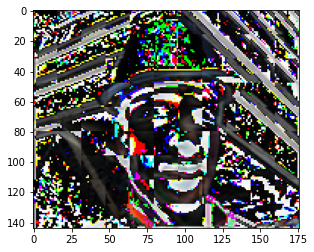

In [21]:
residual, vmin, vmax = scale_to_img(residual)
plt.imshow(residual)
im = Image.fromarray(residual)
im.save("res.jpg")


In [22]:
#residuals -= residuals.min()

In [23]:
#residuals /= residuals.max()

In [24]:
#residuals *= 255
#residuals = residuals.astype(np.uint8)
#residuals

In [25]:
#plt.imshow(residuals), residuals.shape

In [27]:
def codedVector(motion_vector):
    code = bs.Bits(bin= '0b')
    for x in motion_vector:
      code += codeExpGolombExt(x)
    return code

def codeExpGolombExt(number):
  if number > 0:
    value = 2*number - 1
  else:
    value = -2*number
  size = int(np.log2(value+1)) + 1
  code = bs.Bits(bin= '0b0') * (size-1)
  code += bs.Bits(uint= value+1, length= size)
  return code

def readNumber(file_bits: bs.Bits):
  idx = 0
  size = 0
  value = bs.Bits(bin= '0b')

  b = file_bits[idx]

  while(not b):
      size += 1
      idx += 1
      b = file_bits[idx]
  
  for i in range(size+1):
    #print(idx, file_bits.len, size)
    b = file_bits[idx]
    value += bs.Bits(bin= '0b1') if b else bs.Bits(bin= '0b0')
    idx += 1

  value = value.uint - 1
  if value % 2 == 0:
    number = -1*value//2
  else:
    number = (value + 1)//2

  return file_bits[idx:], number

def writeVector(motion_vectors, video_bits):
  for v in motion_vectors:
    video_bits += codedVector(v)
  return video_bits

Códigos a seguir somente para testar as funções:


In [28]:
padding = 0
with open('vectors.em', 'wb') as f:
    bits = writeVector(motion_vectors, bs.Bits(bin= '0b'))
    padding = (8 - (bits.len % 8)) % 8
    bits.tofile(f)

In [29]:
bits = bs.Bits(filename= 'vectors.em')

if padding != 0:
  bits = bits[:-padding]

vector = []
num_blocks = 144//16 * 176//16

for i in range(num_blocks):
  bits, value1 = readNumber(bits)
  bits, value2 = readNumber(bits)
  vector.append((value1, value2))

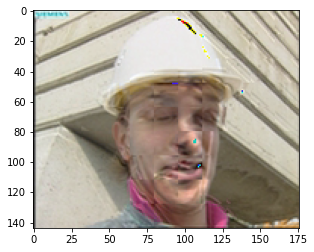

In [30]:
next_frame = build_frame(frame, residual, motion_vectors, block_size)
plt.imshow(next_frame)

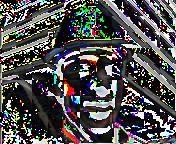

In [31]:
padding = 0
with open('image.em', 'wb') as f:
  with open('res.jpg', 'rb') as f2:
    bits = writeVector(motion_vectors, bs.Bits(bin= '0b'))
    #Tamanho em bytes do vetor (incluso padding)
    bs.Bits(uint= bits.len, length=16).tofile(f)
    bits.tofile(f)
    bs.Bits(uint= int(vmin), length=8).tofile(f)
    bs.Bits(uint= int(vmax), length=8).tofile(f)
    img = f2.read()
    f.write(img)

num_blocks = 144//16 * 176//16
vector = []
with open("image.em", "rb") as f:
  bits_size = int.from_bytes(f.read(2), byteorder='big')
  bytes_used = int(np.ceil(bits_size/8))
  bit_vector = bs.Bits(bytes= f.read(bytes_used))
  vmin_n = int.from_bytes(f.read(1), byteorder='big')
  vmax_n = int.from_bytes(f.read(1), byteorder='big')
  img_bytes = f.read(144*176)
  img = cv2.imdecode(np.frombuffer(img_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
cv2_imshow(img)


In [32]:
def getFrame(video_bytes, first=False):
  num_blocks = 144//16 * 176//16
  vector = []
  offset = 0

  bits_size = int.from_bytes(video_bytes[:2], byteorder='big')
  bytes_used = int(np.ceil(bits_size/8))
  offset = 2 + bytes_used
  bit_vector = bs.Bits(bytes= video_bytes[2:offset], length= bits_size)
  vmin_n = int.from_bytes(video_bytes[offset: offset+1], byteorder='big')
  vmax_n = int.from_bytes(video_bytes[offset+1:offset+2], byteorder='big')
  offset = offset+2
  img_bytes = video_bytes[offset : 144*176 + offset]
  offset = 144*176 + offset
  img = cv2.imdecode(np.frombuffer(img_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

  for i in range(num_blocks):
    bit_vector, value1 = readNumber(bit_vector)
    bit_vector, value2 = readNumber(bit_vector)
    vector.append((value1, value2))

  return np.array(vector), vmin_n, vmax_n, img, video_bytes[offset:]

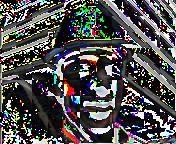

In [33]:
video_bytes = b''
with open("image.em", "rb") as f:
  video_bytes = f.read()

while (video_bytes != b''):
  vector, vmin_n, vmax_n, img, video_bytes = getFrame(video_bytes)
  cv2_imshow(img)